In [1]:
#|default_exp resnet

## Resnets

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStatsCB(append_stats, fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

## Making the model deeper

There are several ways in which the model accuracy can be improved.  One that seems obvious is to make the model deeper. Initially we will look at adding an additional conv layer to create 128 channels, and also making the first layer stride = 1

In [8]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [9]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.801,0.720,0,True
0.853,0.435,0,False
0.884,0.337,1,True
0.886,0.329,1,False
0.902,0.274,2,True
0.896,0.294,2,False
0.924,0.216,3,True
0.910,0.253,3,False
0.940,0.171,4,True
0.916,0.236,4,False


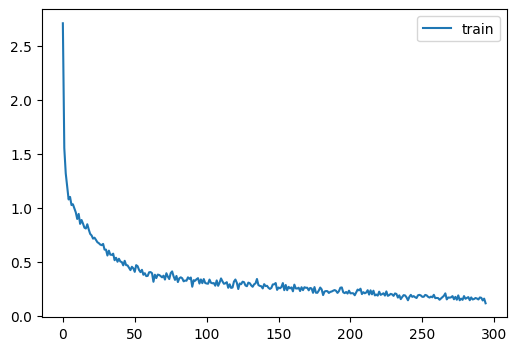

In [10]:
learn.fit(epochs)

## Skip Connections 

The ResNet (*residual network*) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). The key idea is using a *skip connection* to allow deeper networks to train successfully.

<img width="700" src="images/att_00042.png">

The first builsing block for the skip connection network is the creation of a residual block that features both internal cnns and a pass through connection

In [15]:
#|export
def _conv_block(ni, nf, stride, ks=3, act=act_gr, norm=None):
    """ Note that the architectual choice being made here is that the first conv does the re-scaling
    and the second keeps the number of channels the same but reduces the resolution by using stride=2
    
    The pass through block uses a pooling layer to reduce the resolution and then a basic conv to change
    the number of channels to that required
    
    """
    return nn.Sequential(
        conv(ni, nf, stride=1, ks=3, act=act, norm=norm),
        conv(nf, nf, stride=stride, ks=3, act=None, norm=norm)
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        # Create the two convolution layers
        self.convs = _conv_block(ni, nf, stride, ks=ks, act=act, norm=norm)
        # Create the pass through layer.  Note that this can only be a complete pass of the input if ni=nf.
        # Where this is not the case a single conv is used (with no activation and kernel size of 1)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, stride=1, ks=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(kernel_size=2, ceil_mode=True)
        self.act = act()
        
    def forward(self, x):
        return self.act(self.convs(x)) + self.idconv(self.pool(x))
    

**Post-lesson update**: Piotr Czapla noticed that we forgot to include `norm=norm` in the call to `_conv_block` above, so the resnets in the lesson didn't have batchnorm in the resblocks! After fixing this, we discovered that initializing the `conv2` batchnorm weights to zero makes things worse in every model we tried, so we removed that. That init method was originally introduced to handle training extremely deep models (much deeper than we use here) -- it appears from this little test that it might be worse for less deep models.

In [ ]:
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    